# 1D Relativistic  Harmonic Oscillator

Here we solve the Klein-Gordon-Fock equation for the harmonic oscillator (HO) in 1D for a single particle using the NNQS method. The Hamiltonian in units of HO:

$$\hat{H}=-\frac{\hbar^2}{2m}\frac{d²}{dx²}+\frac{1}{2}mw^2\hat{x}^2,$$

where $m$ is the particle mass, and $w$ is the frequency.


## Imports


In [1]:
# Imports
import torch, time
from torch import nn
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt 
from tqdm import tqdm 

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

## General parameters

We define various parameters and hyperparameters.

In [3]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Network hyperparameters
Nin = 1   # Inputs to the neural network
Nout = 1  # Outputs of the neural network
Nhid = 100 # Nodes in the hidden layer

# Network parameters.
seed = 42 # Define the seed 
torch.manual_seed(seed)
# Determine the coefficients for NN (3 layers)
W1 = torch.rand(Nhid, Nin, requires_grad=True)*(-0.1)  
B1 = torch.rand(Nhid, requires_grad=True) * 2. - 1.    
W2 = torch.rand(Nhid, Nhid, requires_grad=True)*(-0.2)        
B2 = torch.rand(Nhid, requires_grad=True) * 2. - 1.    
W3 = torch.rand(Nout, Nhid, requires_grad=True)       

# Training hyperparameters
epochs = 30000
lr = 1e-4  # Learning rate

# Set the frequency 
w = 0.05

# Mesh parameters
Nx = 10000                    # Mesh division
train_a = -8/w**0.5                      # Mesh lower limit
train_b = 8/w**0.5                        # Mesh upper limit
h = (train_b - train_a)/(Nx - 1)  # Grid step
wi = torch.empty(Nx, 1).fill_(h).to(device)     # Integration weights for this mesh. Dirichlet boundary conditions 

  

Y_train = torch.linspace(train_a, train_b, Nx, requires_grad=True, device=device)  

# Analytical Schrodinger solution for the ground state
target = (w/np.pi)**(1/4) * torch.exp(-w*Y_train.pow(2)/2).to(device)

## The neural network

Now we are creating a neural network. Each neural network must be created as a child of the nn.Module class. Inside the __init__ method, we define layers. In our case, we have two hidden layer and therefore two activation function. Inside the with torch.no_grad() block: we define the initial network parameters.

Finally, inside the forward method, we establish connections between various network elements, we establish the network architecture.

In [4]:
class HarmonicNNQS(nn.Module):
    def __init__(self, W1, B1, W2, B2, W3):
        super().__init__()
        
        # We set the operators 
        self.lc1 = nn.Linear(in_features=Nin, 
                             out_features=Nhid, 
                             bias=True)   # shape = (Nhid, Nin)
        self.actfun = nn.Tanh()        # activation function
        self.lc2 = nn.Linear(in_features=Nhid, 
                             out_features=Nhid, 
                             bias=True)  # shape = (Nout, Nhid)
        self.actfun2 = nn.Tanh()        # activation function
        self.lc3 = nn.Linear(in_features=Nhid, 
                             out_features=Nout, 
                             bias=True)  # shape = (Nout, Nhid)
        
        # We set the parameters 
        with torch.no_grad():
            self.lc1.weight = nn.Parameter(W1)
            self.lc1.bias = nn.Parameter(B1)
            self.lc2.bias = nn.Parameter(B2)
            self.lc2.weight = nn.Parameter(W2)
            self.lc3.weight = nn.Parameter(W3)
   
    # We set the architecture
    def forward(self, x): 
        o = self.lc3(self.actfun2(self.lc2(self.actfun(self.lc1(x)))))
        return o


In [5]:
net = HarmonicNNQS(W1, B1, W2, B2, W3).to(device)
print("NN architecture:\n", net)

NN architecture:
 HarmonicNNQS(
  (lc1): Linear(in_features=1, out_features=100, bias=True)
  (actfun): Tanh()
  (lc2): Linear(in_features=100, out_features=100, bias=True)
  (actfun2): Tanh()
  (lc3): Linear(in_features=100, out_features=1, bias=True)
)


In [6]:
optimizer = torch.optim.AdamW(params=net.parameters(), lr=lr, weight_decay=0.1)

## The loss function

$$ m = 1, c = 1, \hbar = 1 $$

$$\newcommand{\bra}[1]{{ \left\langle #1 \right|} }
\newcommand{\ket}[1]{{ \left|  #1 \right\rangle } }
\mathcal{L}=\frac{\langle \psi|\hat{H}_{eff}|\psi\rangle}{\langle \psi|\psi \rangle} + \mu( \langle{\psi}|\psi \rangle -1)^2 +L_{2,regul}. $$

$$ \hat{H}_{eff} = -\frac{1}{2}\frac{d^2}{dx^2} + V_{eff}$$

$$ E_{eff} = \frac{E^2-1}{2} $$
$$ V_{eff} = \frac{2EV(x)-V^2(x)}{2} $$


$$ \bra{\psi_{n,\theta}}\hat{H}_{eff}\ket{\psi_{n,\theta}} = \int_{-\infty}^\infty \bigg\{\frac{1}{2}\bigg(\frac{d\psi_{n,\theta}(x)}{dx}\bigg)^2 + V_{eff})\bigg\}dx $$

With discretization:
$$ \bra{\psi_{n,\theta}}\hat{H}_{eff}\ket{\psi_{n,\theta}} \approx \sum_{i=1}^{N_r} w_i \bigg[\frac{1}{2}\bigg(\frac{d\psi_{n,\theta}(x_i)}{dx}\bigg)^2+ V_{eff})\bigg], $$

$$\bra{\psi_{n,\theta}}\psi_{n,\theta}\rangle\approx \sum_{i=1}^{N_r} w_i \psi_{n,\theta}^2(x_i)\equiv N.$$



In [7]:
def loss_fn(E): 
    mu = 1e-3
    lambd = 0
    psi = net(X)*torch.exp(-w*X.pow(2)/2)
    psi2 = (net(X_det)*torch.exp(-w*X_det.pow(2)/2)).pow(2)
    dpsi_dx, = grad(outputs=psi, 
                    inputs=X,
                    grad_outputs=torch.ones_like(psi), 
                    create_graph=True)            
    
    N = torch.tensordot(psi2, wi)                       
    U_eff = torch.tensordot(psi2 * ( E*w**2*X_det.pow(2)/2 - w**4*X_det.pow(4)/8), wi) / N
    K = (1/2) * torch.tensordot(dpsi_dx.pow(2), wi) / N # Kinetic energy
    regul = torch.tensordot(net.lc1.weight,net.lc1.weight) 
    + torch.tensordot(net.lc2.weight,net.lc2.weight) + torch.tensordot(net.lc3.weight,net.lc3.weight) #regularization
    Norm = mu*w*(torch.tensordot(psi2, wi)-1).pow(2) # Normalization
    
    return K + U_eff + lambd*regul + Norm, U_eff, K, psi, psi / torch.sqrt(N) 

## Plotting

In [8]:
def pic(i, x, psi, psi_normalized, loss, U, K, ax1, ax2, ax3):   
    
    x_cpu = x.detach().cpu().numpy()
    target_cpu = target.detach().cpu().numpy()
    # Overlap
    ax1.set_title('Normalized \n wavefunction')
    wf = psi_normalized.detach().cpu().numpy()
    if np.max(wf) < 0: wf = -wf
    ax1.set_ylim(-0.05, np.max(wf)*1.1)
    if ax1.lines:
        # This will run every time the function is called except the first one
        ax1.lines[0].set_xdata(x_cpu)
        ax1.lines[0].set_ydata(wf)
        ax1.lines[1].set_xdata(x_cpu)
        ax1.lines[1].set_ydata(target_cpu)
    else:
        # This code will only run the first time the function is called
        ax1.plot(x_cpu, wf, label='$\psi_\mathrm{NNQS}$', color='b')
        ax1.plot(x_cpu, target_cpu, linestyle="--", 
                 label='$\psi_\mathrm{Sh}$', color='r')
        ax1.legend()
    
    # Wave function
    ax2.set_title('NNQS \n wavefunction')
    wf = psi.detach().cpu().numpy()
    if np.max(wf) < 0: wf = -wf 
    ax2.set_ylim(-0.05, np.max(wf)*1.1)
    if ax2.lines:
        ax2.lines[0].set_xdata(x_cpu)
        ax2.lines[0].set_ydata(wf)
    else:
        ax2.plot(x_cpu, wf, 
                 label='$\psi_\mathrm{NNQS}$', color='b')
        ax2.legend()

    # Loss
    ax3.set_title("Loss Function")
    ax3.set_xlim(0, i+1)
    x = np.linspace(1, i+1, i+1)
    if ax3.lines:
        for line in ax3.lines:
            line.set_xdata(x)
            y = [U, K, loss, w*(np.ones(i+1)-0.5)][ax3.lines.index(line)]
            line.set_ydata(y)
    else:
        ax3.plot(x, U, label='$U_{eff}$', color='green')
        ax3.plot(x, K, label='$K$', color='gold')
        ax3.plot(x, loss, label='$E$', color='b')
        ax3.plot(x, w*(np.ones(i+1)-0.5), linestyle='--', label='$E_0$', color='r')
        ax3.legend()
        
    fig.canvas.draw()

## Training the network: ground state, $\ket{\psi_0}$

<IPython.core.display.Javascript object>


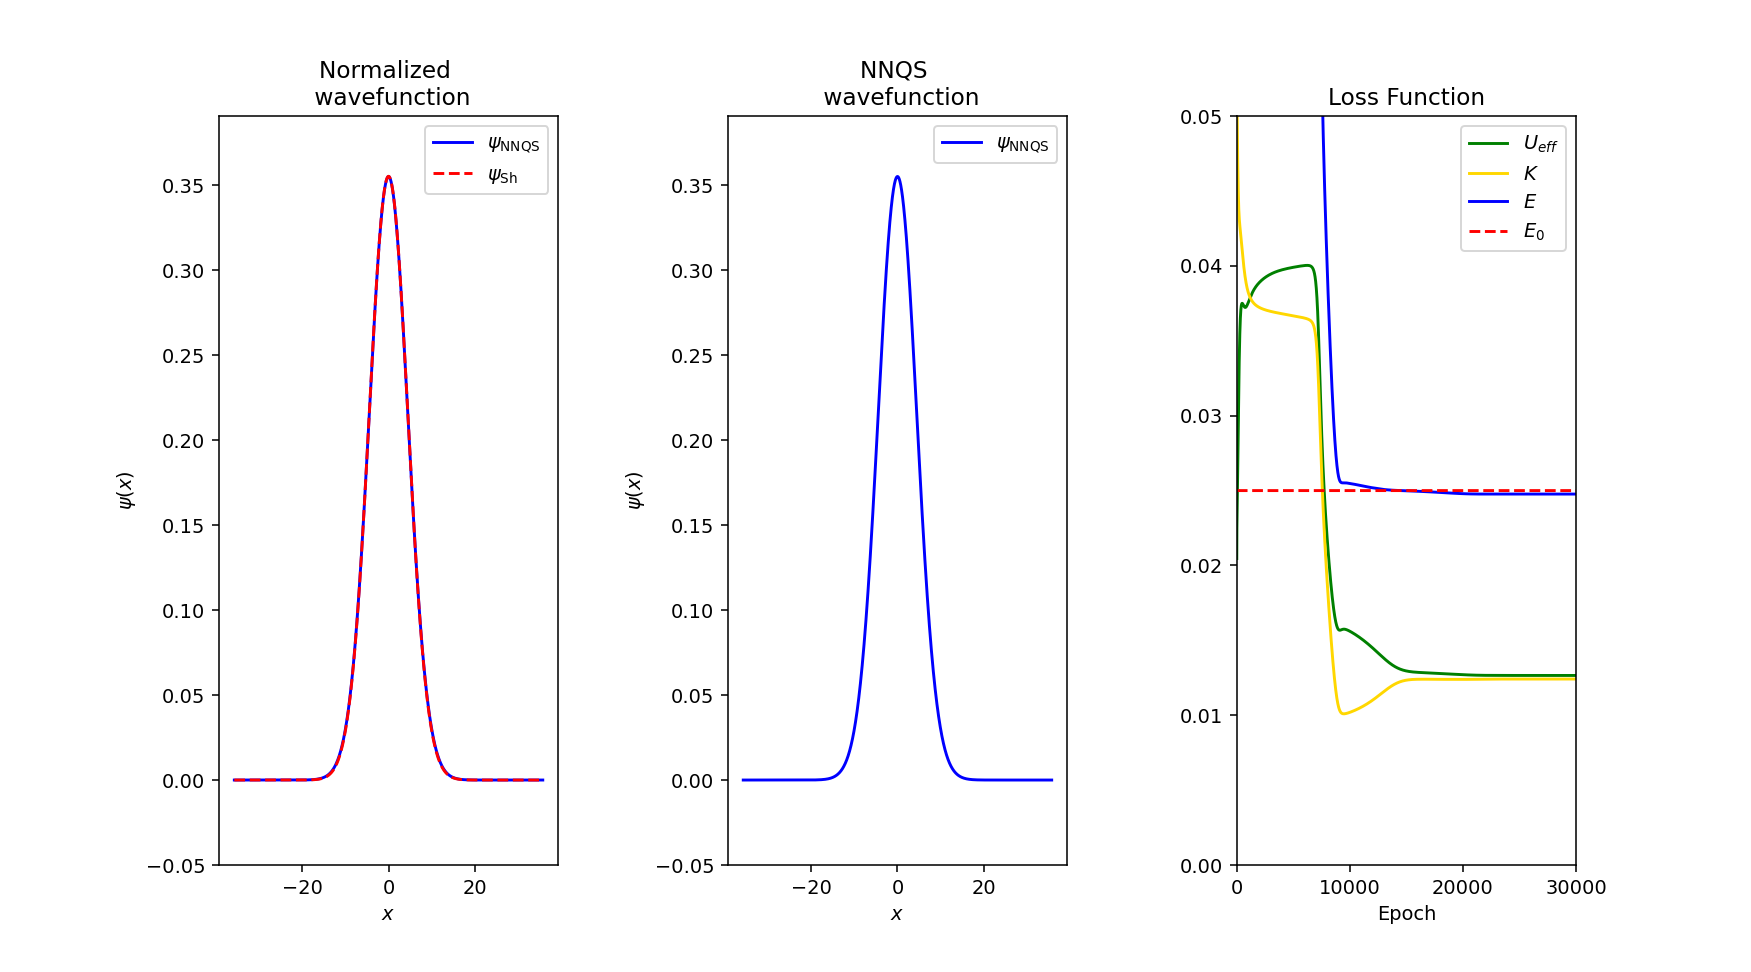

Training the NNQS...: 100%|█████████████████████████████████████████████████████| 30000/30000 [04:16<00:00, 117.07it/s]


In [9]:
set_random_seed(seed)

lambda1 = lambda epoch: 0.9999 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1, last_epoch = -1)

# Plotting
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
ax1, ax2, ax3 = ax[0], ax[1], ax[2]
plt.subplots_adjust(wspace=0.5)

# Overlap
ax1.set_xlabel("$x$")
ax1.set_ylabel("$\psi(x)$")

# Wave function
ax2.set_xlabel("$x$")
ax2.set_ylabel("$\psi(x)$")


# Loss
ax3.set_xlabel("Epoch")
ax3.set_ylim(0, 1.0*w)

loss_accum = []
U_accum = []
K_accum = []
X = Y_train.clone().unsqueeze(1) # Training set
X_det = X.clone().detach() # Training set without gradients

# Set the initial energy
E = 1.0

# Training
for i in tqdm(range(epochs), desc="Training the NNQS..."):       
    loss0, U, K, psi, psi_normalized = loss_fn(E)    
    E = torch.sqrt(2*(U+K)+1).clone().detach()
    

    optimizer.zero_grad() 
    loss0.backward()       
    optimizer.step()      
    
    scheduler.step()
    
    loss_accum.append((E-1).item())
    U_accum.append(U.item())
    K_accum.append(K.item())
    
    if (i == epochs - 1) or (i % 100 == 0): 
        pic(i, Y_train, psi, psi_normalized, loss_accum, U_accum, K_accum, ax1, ax2, ax3)
        time.sleep(0.01)

E0, psi0 = loss_accum[-1], psi.clone().detach()

In [11]:
print('E =',(E-1).item())

E = 0.024767279624938965


## Training the network: first excited state, $\ket{\psi_1}$

Now let's move on to the first excited state. The process is almost identical to the process of finding the ground state wave function, but we need to 

$$ \langle\psi_{0,\theta}|\psi_{1,\theta'}\rangle = 0, $$

where $\psi_{0,\theta}, \psi_{1,\theta'}$ are the wave functions of the paragraph of the ground and first excited states, respectively. An easy way to impose this condition is to make $\psi_1$antisymmetric (given that $\psi_0$ is symmetric),

$$ \psi_{1,\theta'}(x) \rightarrow \psi_{1,\theta'}(x)-\psi_{1,\theta'}(-x) .$$

 

In [12]:
target = ((2 / np.sqrt(2))*(np.power(w/np.pi, 1/4))*torch.exp(-w*Y_train.pow(2) / 2)*w**0.5*Y_train).to(device)

In [13]:
def loss_fn_prime(E): 
    mu = 1
    lambd = 0
    X_det = X.clone().detach()
    psi = (net1(X)+net1(-X))*torch.exp(-w*X.pow(2)/2)*X*w**0.5
    psi2 = psi.pow(2)
    dpsi_dx, = grad(outputs=psi, 
                    inputs=X,
                    grad_outputs=torch.ones_like(psi), 
                    create_graph=True)            
    
    # Energy term
    N = torch.tensordot(psi2, wi)                       
    U_eff = torch.tensordot(psi2 * ( E*w**2*X_det.pow(2)/2 - w**4*X_det.pow(4)/8), wi) / N  
    K = (1/2) * torch.tensordot(dpsi_dx.pow(2), wi) / N   
    regul = torch.tensordot(net1.lc1.weight,net1.lc1.weight) 
    + torch.tensordot(net1.lc2.weight,net1.lc2.weight) + torch.tensordot(net1.lc3.weight,net1.lc3.weight)
    Norm = mu*w*(torch.tensordot(psi2, wi)-1).pow(2) # Normalization
    
    return K + U_eff + lambd*regul + Norm, U_eff, K, psi, psi / torch.sqrt(N) 

Now we are defining a new neural network that has exactly the same architecture as the one used for the ground state. We can do this by creating a new object of our NNQS class. We also reset the parameters of the optimizer, redefining it.

In [14]:
epochs = 30000
lr = 5e-4  # Learning rate
net1 = HarmonicNNQS(W1, B1, W2, B2, W3).to(device)
optimizer = torch.optim.AdamW(params=net1.parameters(), lr=lr, weight_decay=0.1)



We are defining a new plotting function,

In [15]:
def pic(i, x, psi, psi_normalized, loss, U, K, ax1, ax2, ax3):   
    
    x_cpu = x.detach().cpu().numpy()
    target_cpu = target.detach().cpu().numpy()
    # Overlap
    ax1.set_title('Normalized \n wavefunction')
    wf = psi_normalized.detach().cpu().numpy()
    if net1(torch.tensor([[-2.]]).to(device)).item() > 0.: wf *= -1
    lim_inf, lim_sup = min(min(wf), min(target_cpu)), max(max(wf), max(target_cpu))
    ax1.set_ylim(lim_inf*1.1, lim_sup*1.1)
    if ax1.lines:
        # This will run every time the function is called except the first one
        ax1.lines[0].set_xdata(x_cpu)
        ax1.lines[0].set_ydata(wf)
        ax1.lines[1].set_xdata(x_cpu)
        ax1.lines[1].set_ydata(target_cpu)
    else:
        # This code will only run the first time the function is called
        ax1.plot(x_cpu, wf, label='$\psi_\mathrm{NNQS}$', color='b')
        ax1.plot(x_cpu, target_cpu, linestyle="--", 
                 label='$\psi_\mathrm{Sh}$', color='r')
        ax1.legend()
    
    # Wave function
    ax2.set_title('NNQS \n wavefunction')
    wf = psi.detach().cpu().numpy()
    if net1(torch.tensor([[-2.]]).to(device)).item() > 0.: wf *= -1
    lim_inf, lim_sup = min(min(wf), min(target_cpu)), max(max(wf), max(target_cpu))
    ax2.set_ylim(lim_inf*1.1, lim_sup*1.1)
    if ax2.lines:
        ax2.lines[0].set_xdata(x_cpu)
        ax2.lines[0].set_ydata(wf)
    else:
        ax2.plot(x_cpu, wf, 
                 label='$\psi_\mathrm{NNQS}$', color='b')
        ax2.legend()

    # Loss
    ax3.set_title("Loss Function")
    ax3.set_xlim(0, i+1)
    x = np.linspace(1, i+1, i+1)
    if ax3.lines:
        for line in ax3.lines:
            line.set_xdata(x)
            y = [U, K, loss, w*(np.ones(i+1)+0.5)][ax3.lines.index(line)]
            line.set_ydata(y)
    else:
        ax3.plot(x, U, label='$U_{eff}$', color='green')
        ax3.plot(x, K, label='$K$', color='gold')
        ax3.plot(x, loss, label='$E$', color='b')
        ax3.plot(x,  w*(np.ones(i+1)+0.5), linestyle='--', label='$E_1$', color='r')
        ax3.legend()
        
    fig.canvas.draw()

<IPython.core.display.Javascript object>


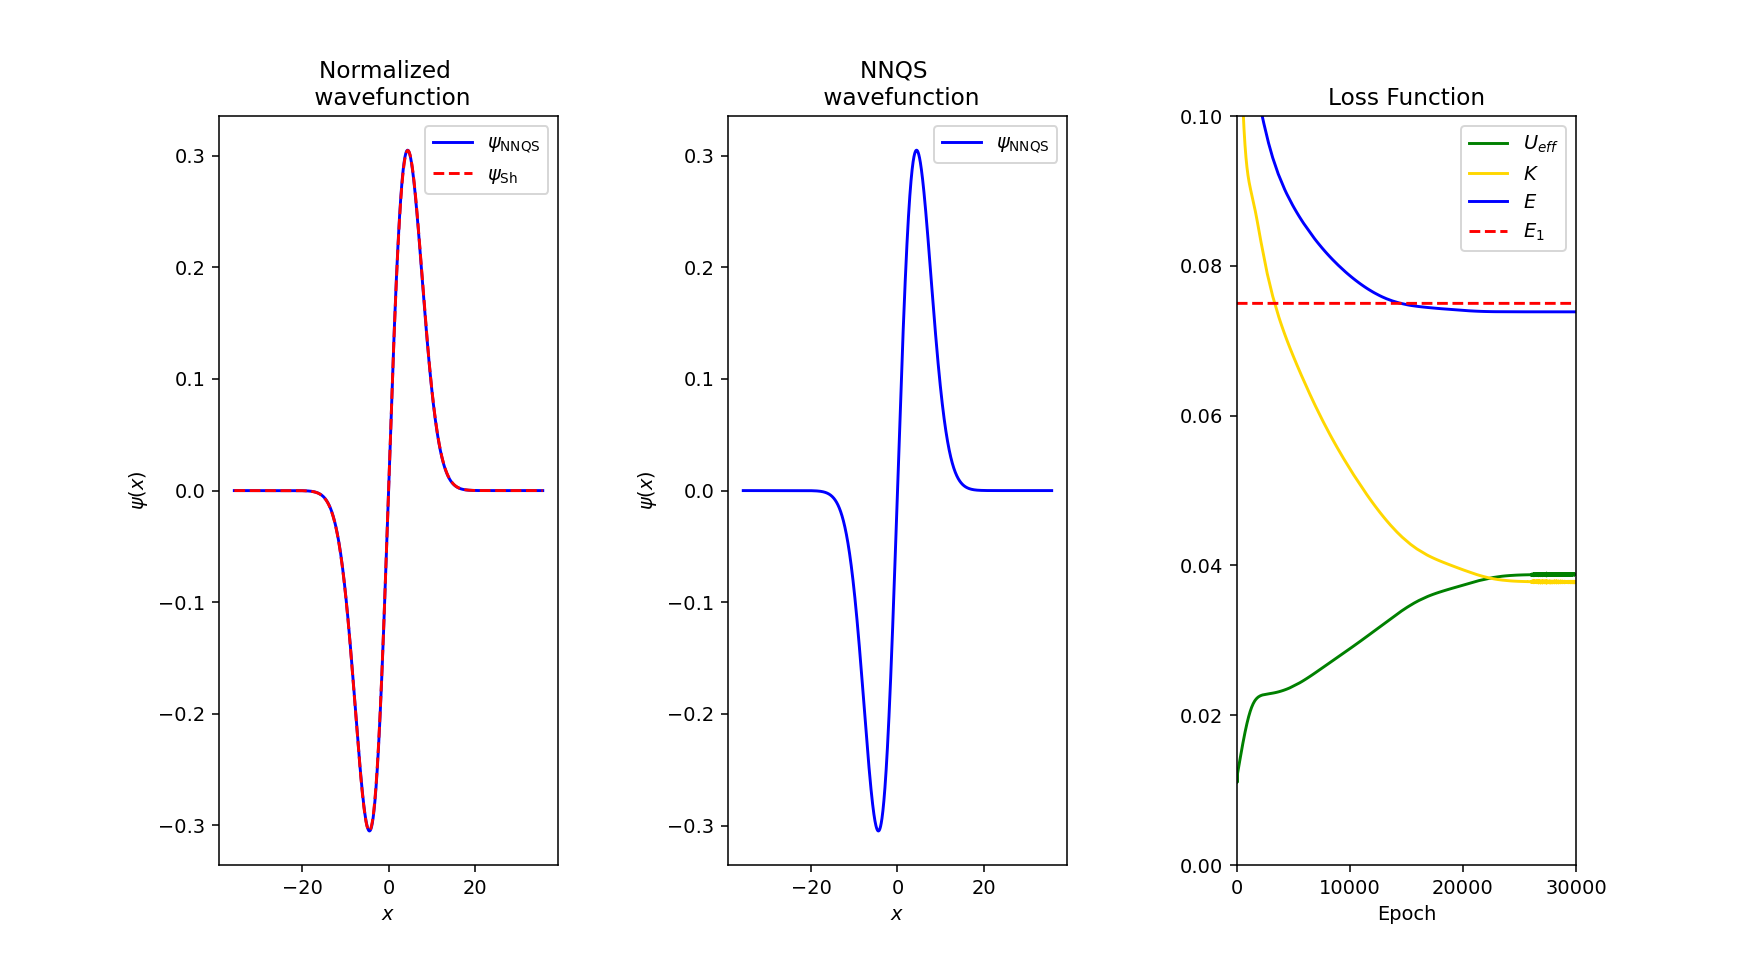

Training the NNQS...: 100%|██████████████████████████████████████████████████████| 30000/30000 [05:48<00:00, 86.13it/s]


In [16]:
set_random_seed(seed)

lambda1 = lambda epoch: 0.9999 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1, last_epoch = -1)

# Plotting
%matplotlib notebook
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 5))
ax1, ax2, ax3 = ax[0], ax[1], ax[2]
plt.subplots_adjust(wspace=0.5)

# Overlap
ax1.set_xlabel("$x$")
ax1.set_ylabel("$\psi(x)$")

# Wave function
ax2.set_xlabel("$x$")
ax2.set_ylabel("$\psi(x)$")


# Loss
ax3.set_xlabel("Epoch")
ax3.set_ylim(0, 2.0*w)

loss_accum = []
U_accum = []
K_accum = []
X = Y_train.clone().unsqueeze(1)

E = 1.0

# Training
for i in tqdm(range(epochs), desc="Training the NNQS..."):
    loss, U, K, psi, psi_normalized = loss_fn_prime(E)    
    
    E = torch.sqrt(2*(K+U)+1).clone().detach()
    optimizer.zero_grad() 
    loss.backward()       
    optimizer.step()      
    
    scheduler.step()
    
    loss_accum.append((E-1).item())
    U_accum.append(U.item())
    K_accum.append(K.item())
    
    if (i == epochs - 1) or (i % 100 == 0):
        pic(i, Y_train, psi, psi_normalized, loss_accum, U_accum, K_accum, ax1, ax2, ax3)
        time.sleep(0.01)
        
E1, psi1 = loss_accum[-1], psi

In [17]:
print('E =',(E-1).item())

E = 0.0738677978515625
